# Demo of Visually Grounded Story Generation


# Environment

In [ ]:
!pip install tqdm numpy pandas matplotlib openai datasets

In [ ]:
import os
import math
from collections import defaultdict
import requests
from PIL import Image
from io import BytesIO
import base64

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
from datasets import load_dataset


In [ ]:
IMG_PATH = 'images'

# OpenAI API Key
api_key = "YOUR_OPENAI_API_KEY" # Replace this with your real API key
openai.api_key = api_key

## Data loading

In [ ]:
# Load the dataset
dataset = load_dataset("tonyhong/vwp")

# Convert the dataset to a pandas DataFrame
vwp = pd.DataFrame(dataset['val'])


In [ ]:
vwp.shape

(849, 36)

In [ ]:
val_data = vwp.query("split=='val'")
val_data.head()

,scene_full_id,link0,link1,link2,link3,link4,link5,link6,link7,link8,...,text5,text6,text7,text8,text9,img_id_list,story,sep_story,split,imdb_id
0,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...",James and Thelma were spying on their neighbor...,James and Thelma were spying on their neighbor...,val,tt0047396
1,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,...,The police arrive as Raymond is in darkness.,James and Thelma are relieved.,Raymond stands at his front door.,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...",Graces runs from a door as Raymond approaches....,Graces runs from a door as Raymond approaches....,val,tt0047396
2,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,None,None,"['tt0047396_0668_0', 'tt0047396_0669_0', 'tt00...",James is calling the cops. He and Thelma are t...,James is calling the cops. He and Thelma are t...,val,tt0047396
3,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,None,None,"['tt0047396_0667_0', 'tt0047396_0668_0', 'tt00...","From the opposite apartment, Grace flees the a...","From the opposite apartment, Grace flees the a...",val,tt0047396
4,tt0047396_0010_0,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,https://datasets.d2.mpi-inf.mpg.de/xhong/VST/a...,None,None,None,None,...,None,None,None,None,None,"['tt0047396_0667_0', 'tt0047396_0669_0', 'tt00...",Raymond approached the door to the apartment. ...,Raymond approached the door to the apartment. ...,val,tt0047396


In [ ]:
small_val_data = val_data.head().copy()
small_val_data['output'] = ''
small_val_data.shape

(5, 37)

In [ ]:
small_val_data.keys()

Index(['scene_full_id', 'link0', 'link1', 'link2', 'link3', 'link4', 'link5',
       'link6', 'link7', 'link8', 'link9', 'char0', 'char1', 'char2', 'char3',
       'char4', 'char0_url', 'char1_url', 'char2_url', 'char3_url',
       'char4_url', 'text0', 'text1', 'text2', 'text3', 'text4', 'text5',
       'text6', 'text7', 'text8', 'text9', 'img_id_list', 'story', 'sep_story',
       'split', 'imdb_id', 'output'],
      dtype='object')

## Functions

In [ ]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Get image descriptions
def generate_image_description(image_path):
    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }
    # Getting the base64 string
    if image_path[:5] != 'https':
        base64_image = encode_image(image_path)
        url = f"data:image/jpeg;base64,{base64_image}"
    else:
        url = image_path
    payload = {
        "model": "gpt-4-vision-preview",
        "max_tokens": 200,
        "messages" : [
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": "What’s in this image?"
              },
              {
                "type": "image_url",
                "image_url": {
                  "url": url,
                }
              }
            ]
          }
        ]
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']

# Function to generate a story based on descriptions of multiple images
def generate_story(descriptions):
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {
            "role": "user",
            "content": "Write a coherent story based on the following image descriptions: " + " ".join(descriptions) + " ####  Return just the story and nothing else",
          }
        ],
        temperature=0,
        max_tokens=300,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    story = response.choices[0].message.content
    return story

# Get descriptions from all images
def image_captioning(image_paths):
    descriptions = []
    for image_idx, image_path in tqdm(enumerate(image_paths)):
        description_response = generate_image_description(image_path)
        #print(f"Description of Image {image_idx+1}:", description_response, '\n')
        descriptions.append(description_response)
    return descriptions

# Get a story directly
def visual_storytelling(image_paths):
    url_list = []
    for image_idx, image_path in tqdm(enumerate(image_paths)):
        # Getting the base64 string
        if image_path[:5] != 'https':
            base64_image = encode_image(image_path)
            url = f"data:image/jpeg;base64,{base64_image}"
        else:
            url = image_path
        url_list.append(url)

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }
    content = [
              {
                "type": "text",
                "text": "These are frames from a video. Write a coherent short story using no more than 100 words based on these frames. Return just the story and nothing else. "
              }
            ]
    for url in url_list:
        content.append({
                "type": "image_url",
                "image_url": {
                  "url": url,
                }
              })
    payload = {
        "model": "gpt-4-vision-preview",
        "max_tokens": 300,
        "messages" : [
          {
            "role": "user",
            "content": content,
          }
        ]
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']

In [ ]:
data = small_val_data
data.keys()

Index(['scene_full_id', 'link0', 'link1', 'link2', 'link3', 'link4', 'link5',
       'link6', 'link7', 'link8', 'link9', 'char0', 'char1', 'char2', 'char3',
       'char4', 'char0_url', 'char1_url', 'char2_url', 'char3_url',
       'char4_url', 'text0', 'text1', 'text2', 'text3', 'text4', 'text5',
       'text6', 'text7', 'text8', 'text9', 'img_id_list', 'story', 'sep_story',
       'split', 'imdb_id', 'output'],
      dtype='object')

## Example: 1-stage generation generation using local images

Index:  703
Images: 


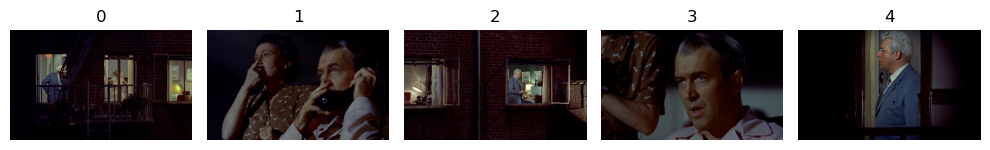

Human story:  James and Thelma were spying on their neighbor Raymond's apartment. James noticed an underage girl in the apartment with Raymond. He was worried so he called the police. James saw Raymond take a knife out of his drawer. James couldn't believe what he was seeing. The cops finally got to Raymond's apartment. He was stunned.  



5it [00:00, 329.41it/s]


Generated story:  Under cover of night, a mysterious figure scaled the building's facade. Neighbors, drawn by the commotion, peered through windows, whispering theories. Inside, a worried couple called for help, eyes tracing every move of the stranger. Across the courtyard, a lone man watched intently, unfazed by the turn of events. The figure's purpose, unclear to the onlookers, was a silent dance with danger. As tension hung in the night air, a fleeting glance exchanged between the couple suggested they knew more than they let on. The man in the shadows took notes, the plot thickening with his every stroke. 




In [ ]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']
    img_id_list = eval(data.loc[idx, 'img_id_list'])

    print('Index: ', idx)
    print('Images: ')
    image_paths = [os.path.join(IMG_PATH, img_id+'.jpg') for img_id in img_id_list]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the storyteller to generate story
    print('Human story: ', human_story, '\n')

    generated_story = visual_storytelling(image_paths)
    print('Generated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break


## 2-stage generation using images on the server

Index:  703
Images: 


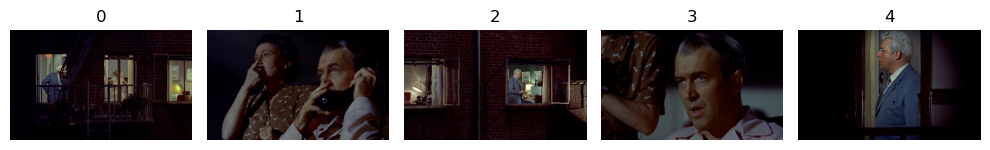

5it [00:26,  5.34s/it]


Image descriptions: 
0 The image shows the exterior of a brick building at night. There's a balcony with an iron railing that has some plants and flowers on it. A fire escape ladder is visible, leading up to a partly open window. Inside, we can see a warmly lit room, and it appears that there's a person standing close to the window. The scene has a quiet, perhaps intimate or solitary atmosphere.
1 The image depicts two individuals, likely a man and a woman, situated in a dimly-lit environment. The woman appears to be looking intently with her hand to her mouth, suggesting a reaction of suspense or concern. The man is holding a pair of binoculars up to his eyes, suggesting that he is observing something at a distance with great interest. The style of clothing and the image quality suggest that this scene might be from a film made in the mid-20th century. The overall atmosphere indicates a moment of tension, which is common in thriller or drama genres.
2 The image shows a scene of an int

In [ ]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']

    print('Index: ', idx)
    print('Images: ')
    image_paths = [data.loc[idx, 'link'+str(p)] for p in range(9) if not pd.isna(data.loc[idx, 'link'+str(p)])]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            response = requests.get(image_paths[i])
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the captioner to generate image descriptions
    descriptions = image_captioning(image_paths)
    print('Image descriptions: ')
    [print(i, descriptions[i]) for i in range(len(descriptions))]

    # Call the storyteller to generate story
    print('Human story: ', human_story, '\n')

    generated_story = generate_story(descriptions)
    print('Generated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break


## 2-stage generation using local images

Index:  703
Images: 


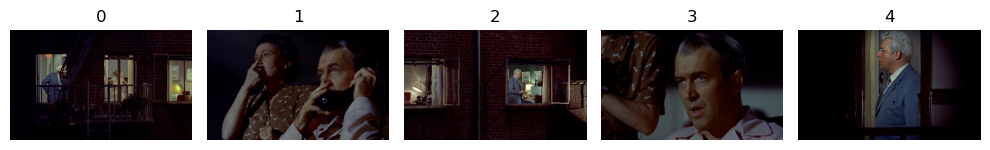

5it [00:39,  7.87s/it]


Image descriptions: 
0 The image depicts a nighttime scene of a brick building with multiple windows. There are various objects and details that can be seen:

1. Fire escape: A metal fire escape staircase is visible on the left side of the frame, suggesting this is a multi-story urban building.

2. Window view: Inside one of the brightly lit windows, it appears that there is a person standing, although the details are not clear.

3. Exterior details: On the balcony railing, there are flower pots, indicating someone has decorated this outdoor space.

4. Interior glimpse: Through the windows, you can see the interior lighting and some wall decorations, which give the impression of a cozy, inhabited space.

It's important to note that my responses are based on the visual content of the image, without any knowledge of its context that isn't visually represented.
1 This image depicts a scene with two individuals, one male and one female, sitting side by side. The man appears to be listening

In [ ]:
cnt = 0
for idx in data.index:
    scene_full_id = data.loc[idx, 'scene_full_id']
    img_id_list = eval(data.loc[idx, 'img_id_list'])

    print('Index: ', idx)
    print('Images: ')
    image_paths = [os.path.join(IMG_PATH, img_id+'.jpg') for img_id in img_id_list]
    human_story = data.loc[idx, 'story']

    length_y = math.ceil(len(image_paths) / 5)
    fig, axs = plt.subplots(length_y, 5, figsize=(10, 2*length_y))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

    # Call the captioner to generate image descriptions
    descriptions = image_captioning(image_paths)
    print('Image descriptions: ')
    [print(i, descriptions[i]) for i in range(len(descriptions))]

    # Call the storyteller to generate story
    print('Human story: ', human_story, '\n')

    generated_story = generate_story(descriptions)
    print('Generated story: ', generated_story, '\n')
    print()

    cnt += 1
    if cnt > 0:
        break


## Using Functions

In [ ]:
descriptions = image_captioning(image_paths)
# print('Descriptions: ', descriptions)

4it [00:25,  6.61s/it]

In [ ]:
# Write a story with image descriptions
generated_story = generate_story(descriptions)
print('Story: ', generated_story)